<a href="https://colab.research.google.com/github/cesar-claros/synergistic/blob/master/imdb_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch
!pip install gpytorch

In [ ]:
! sudo apt-get install texlive-latex-recommended #1
! sudo apt-get install dvipng texlive-fonts-recommended #2
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
! unzip type1cm.zip -d /tmp/type1cm #4
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7
! sudo texhash #8

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!cp -r "drive/My Drive/NIPS2020/auxfunc/" .
!cp -r "drive/My Drive/NIPS2020/datasets/" .
!cp -r "drive/My Drive/NIPS2020/style/" .
!cp -r "drive/My Drive/NIPS2020/runs/" .

In [ ]:
%load_ext tensorboard

In [5]:
# Imports
import io #Used as buffer
import sys
import matplotlib
import tensorflow as tf # Keras model for MNIST 
# matplotlib.use('qt5Agg')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import auxfunc.sigfunc as sgn
import seaborn as sns
import torch
from scipy.stats import entropy, spearmanr
from sklearn import model_selection, svm, ensemble, linear_model, pipeline, \
      tree, neighbors, discriminant_analysis, gaussian_process, preprocessing, impute, decomposition
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern
plt.style.use(['ggplot','style/style.mplstyle'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
#%%
# Define LSTM architecture
def LSTM_model(top_words, emb_vector_length, max_review_length, objective, reg=0.01):
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(top_words,emb_vector_length,input_length=max_review_length))
    model.add(tf.keras.layers.LSTM(100))
    if objective == 'svm':
        model.add(tf.keras.layers.Dense(
            units=1, kernel_initializer='uniform', activation='linear', kernel_regularizer=tf.keras.regularizers.l2(reg)
        ))
    elif objective == 'softmax':
        model.add(tf.keras.layers.Dense(
            units=1, kernel_initializer='uniform', activation='sigmoid'
        ))
    return model

In [7]:
#%%
# Signaling function fitting and evaluation
def signalingFunction(X_train, y_train, y_train_pred_th, X_val, y_val, y_val_pred_th, X_test, y_test, y_test_pred_th, kernel='exponential', norm='l01'):
    # X_train, X_val should be scaled
    # Fit signaling function 
    exp = sgn.signaling(norm=norm) # idx = [train,test,val]
    exp.fit(X_train, y_train, y_train_pred_th, kernel=kernel, n_iter=500, lr=0.01)
    table_val = exp.evaluate(X_val, y_val, y_val_pred_th, rule_grid=np.linspace(0,3,30, endpoint=False))
    table_test = exp.test(X_test, y_test, y_test_pred_th, table_val['rule'].to_numpy(), table_val['eta'].to_numpy())
    table = pd.concat([table_val,table_test],axis=1)
    return table, exp

In [8]:
#%%
# Initialize model
def init_model(input_dim, objective):
    model = LSTM_model(top_words, emb_vector_length, max_review_length, objective)
    if objective=='svm':
        loss = tf.keras.losses.hinge
        metric = ['hinge']

    elif objective=='softmax':
        loss = tf.keras.losses.binary_crossentropy
        metric = ['accuracy']

    model.compile(loss=loss,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=metric)
    # model.summary()
    print('loss={}'.format(loss.__name__))
    return model

In [9]:
#%%
# Soft and thresholded output predictions
def pred_output(model, X, objective):
    if objective=='svm':
        y_pred_soft = model.predict(X)
        y_pred_th = np.array([1 if i[0] >= 0 else 0 for i in y_pred_soft])
    elif objective=='softmax':
        y_pred_soft = model.predict(X)
        y_pred_th = np.array([1 if i[0] > 0.5 else 0 for i in y_pred_soft])
    return y_pred_soft, y_pred_th

In [10]:
#%%
# Jaccard similarity index
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [11]:
#%%
# Baseline comparison
def baselineCriteria(y_val, y_val_pred_soft, y_val_pred_th, y_test, y_test_pred_soft, y_test_pred_th, table, exp, clf):
      if clf=='svm':
          direction = 'closer'
          crit_val = np.abs(y_val_pred_soft.ravel())
          crit_test = np.abs(y_test_pred_soft.ravel())
      else:
          direction = 'further'
          p_val = np.concatenate((y_val_pred_soft,1-y_val_pred_soft),axis=1)
          crit_val = entropy(p_val, axis=1, base=2)
          p_test = np.concatenate((y_test_pred_soft,1-y_test_pred_soft),axis=1)
          crit_test = entropy(p_test, axis=1, base=2)
      
      critFunc = sgn.critEvaluation(norm='l01',direction=direction)
      d_val = critFunc.evaluate(y_val, y_val_pred_th, crit_val)
      d_test = critFunc.test(y_test, y_test_pred_th, crit_test, d_val['thresh'].to_numpy())
      crit_table = pd.concat([d_val,d_test],axis=1)

      gamma = table['rule'].to_numpy().reshape(-1,1)
      f_test = exp.gpr_mean_test + gamma*np.sqrt(exp.gpr_var_test)
      eta = table['eta'].to_numpy().reshape(-1,1)
      theta = crit_table['thresh'].to_numpy().reshape(-1,1)
      if direction == 'closer':
        f_mask, f_idx = np.nonzero(f_test>eta)
      else:
        f_mask, f_idx = np.nonzero(f_test<eta)
      crit_mask, crit_idx = np.nonzero(crit_test.reshape(1,-1)<theta)
      print(list(np.unique(f_mask)))
      print(list(np.unique(crit_mask)))
      print(f_test.shape[0])
      shared = set(list(np.unique(f_mask))).intersection(set(list(np.unique(crit_mask))))
      J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) if i in shared else np.nan for i in range(f_test.shape[0])]
      # if (list(np.unique(f_mask))==list(np.unique(crit_mask))):
      #   J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) for i in np.unique(f_mask)]
      # else:
      #   shared = set(a).intersection(set(b))
      #   union = set(a).union(set(b))
      #   J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) if i in shared else np.nan  for i in union]
      crit_table['jaccard']=J
      Sp = [spearmanr(f_test[i,:],crit_test)[0] for i in range(f_test.shape[0])]
      crit_table['spearman'] = Sp
      crit_table['gamma'] = gamma
      return crit_table

In [12]:
# %%
# INITIALIZATION
# ==============
# EXPERIMENT SETUP
# ================
top_words = 5000
max_review_length = 500
emb_vector_length = 32
# Load data set
(Data_X, Data_y), (X_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=top_words)
Data_X = tf.keras.preprocessing.sequence.pad_sequences(Data_X, maxlen=max_review_length)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_review_length)
print("Number of original training examples:", len(Data_X))

17465344/17464789 [==============================] - 0s 0us/step
Number of original training examples: 25000


In [37]:
# For reproducibility
tf.random.set_seed(54321)
np.random.seed(12345)
torch.manual_seed(0)
#%%
# Assign labels
report_table = []
report_criteria = []
report_plot = []
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=123)
clf = 'softmax'
addPredictions = True
applyPCA = False
accuracy = 0
for sample, test in kf.split(Data_X):
    sample = sample[:12500]
    test = test[:2000]
    X = Data_X[sample]
    y = Data_y[sample]
    X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, test_size=0.20, random_state=123)
    X_test = Data_X[test]
    y_test = Data_y[test]

    # TRAINING MODEL
    model = init_model(input_dim=X.shape[1], objective=clf)
    model.fit(X_train, y_train, batch_size=64, epochs=5, verbose=0, validation_data=(X_val, y_val))
    # X_test = scaleX.transform(imputeX.transform(X_test))

    y_train_pred_soft, y_train_pred_th = pred_output(model, X_train, clf)
    print('accuracy(Train)={}'.format(np.sum(y_train==y_train_pred_th)/np.size(y_train)))
    y_val_pred_soft, y_val_pred_th = pred_output(model, X_val, clf)
    # print('accuracy(Val)={}'.format(np.sum(y_val==y_val_pred_th)/np.size(y_val)))
    y_test_pred_soft, y_test_pred_th = pred_output(model, X_test, clf)

    layer_outputs = [layer.output for layer in model.layers] 
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
    X_train_GP = activation_model.predict(X_train)[1]
    X_val_GP = activation_model.predict(X_val)[1]
    X_test_GP = activation_model.predict(X_test)[1]

    if addPredictions:
            # Add predictions
            X_train_GP = np.concatenate((X_train_GP, y_train_pred_soft), axis=1)
            X_val_GP = np.concatenate((X_val_GP, y_val_pred_soft), axis=1)
            X_test_GP = np.concatenate((X_test_GP, y_test_pred_soft), axis=1)
    scaleX_GP = preprocessing.StandardScaler().fit(np.concatenate((X_train_GP, X_val_GP), axis=0))
    X_train_GP = scaleX_GP.transform(X_train_GP)
    X_val_GP = scaleX_GP.transform(X_val_GP)
    X_test_GP = scaleX_GP.transform(X_test_GP)
    if applyPCA:
            pca_GP = decomposition.PCA(.99).fit(np.concatenate((X_train_GP, X_val_GP), axis=0)) # set percentage of energy preserved by PCA
            # Apply PCA transform to all sets
            X_train_GP = pca_GP.transform(X_train_GP)
            X_val_GP = pca_GP.transform(X_val_GP)
            X_test_GP = pca_GP.transform(X_test_GP)

    table, exp = signalingFunction(X_train_GP, y_train, y_train_pred_th, X_val_GP, y_val, y_val_pred_th, X_test_GP, y_test, y_test_pred_th)
    report_table.append(table)
    # Baseline for comparison
    crit_table = baselineCriteria(y_val, y_val_pred_soft, y_val_pred_th, y_test, y_test_pred_soft, y_test_pred_th, table, exp, clf)
    report_criteria.append(crit_table)

    score = np.sum(y_val==y_val_pred_th)/np.size(y_val)
    if accuracy < score:
      accuracy = score
      table_best = table
      crit_table_best = crit_table
      exp_best = exp
      y_test_best = y_test
      y_test_pred_soft_best = y_test_pred_soft
      y_test_pred_th_best = y_test_pred_th
      X_test_best = X_test
    del(model)

loss=binary_crossentropy
accuracy(Train)=0.9502
initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: -0.310  noise: 0.019
Iter 492/500 - Loss: -0.311  noise: 0.019
Iter 493/500 - Loss: -0.315  noise: 0.019
Iter 494/500 - Loss: -0.311  noise: 0.019
Iter 495/500 - Loss: -0.312  noise: 0.019
Iter 496/500 - Loss: -0.312  noise: 0.018
Iter 497/500 - Loss: -0.316  noise: 0.018
Iter 498/500 - Loss: -0.313  noise: 0.018
Iter 499/500 - Loss: -0.311  noise: 0.018
Iter 500/500 - Loss: -0.315  noise: 0.018
evaluating with cuda...
evaluating with cuda...
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
5
loss=binary_crossentropy
accuracy(Train)=0.8687
initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: 0.177  noise: 0.054
Iter 492/500 - Loss: 0.178  noise: 0.054
Iter 493/500 - Loss: 0.177  noise: 0.054
Iter 494/500 - Loss: 0.176  noise: 0.054
Iter 495/500 - Loss: 0.176  noise: 0.054
Iter 496/500 - Loss: 0.179  noise: 0.054
Iter 497/500 - Loss: 0.177  noise: 0.054
Iter 498/500 - Loss: 

In [ ]:
logs_base_dir = "runs/"
%tensorboard --logdir {logs_base_dir}

In [38]:
##%
# Boxplot (loss reduction in test set)
report_table_concat = pd.concat(report_table)
cols_table = ['p_value','rho_user','%reduction_test']
df_boxplot_table = pd.DataFrame(report_table_concat[cols_table])
df_boxplot_table['label'] = df_boxplot_table.shape[0]*['$f(x)$']
report_criteria_concat = pd.concat(report_criteria)
columns_crit = ['rho_user','%reduction_test']
df_boxplot_crit = pd.DataFrame(report_criteria_concat[columns_crit])
df_boxplot_crit['label'] = df_boxplot_crit.shape[0]*['$g(x)$']
# p-value median
p_value_by_row_index = df_boxplot_table['p_value'].groupby(df_boxplot_table.index)
p_value_median = p_value_by_row_index.median()
# Boxplot (jaccard index in test set)
columns_jac = ['rho_user','jaccard']
df_jaccard = pd.DataFrame(report_criteria_concat[columns_jac])
# Unfiltered Result dataframes
cols_fx = ['rho_user','%reduction_val','budget','%reduction_test']
results_fx = pd.DataFrame(report_table_concat[cols_fx])
cols_fxgx = ['rho_user','%reduction_test', 'jaccard']
results_fxgx = pd.concat([df_boxplot_table[cols_fxgx[:2]], df_boxplot_crit[cols_fxgx[1]], df_jaccard[cols_fxgx[2]]], axis=1)
# Filter experiments with p_value > 0.05
df_boxplot_crit = df_boxplot_crit.loc[df_boxplot_table['p_value'] <= 0.05]
df_jaccard = df_jaccard.loc[df_boxplot_table['p_value'] <= 0.05]
df_boxplot_table = df_boxplot_table.loc[df_boxplot_table['p_value'] <= 0.05]
# Boxplot with filtered values only
frames = [df_boxplot_table, df_boxplot_crit]
df = pd.concat(frames)

In [39]:
# Avoid plotting when median(p_value)>0.5
for i in range(p_value_median.shape[0]):
    if p_value_median.iloc[i]>0.05:
      df.loc[df.index==i,'%reduction_test'] = np.nan
      df_jaccard.loc[df_jaccard.index==i, 'jaccard'] = np.nan

In [40]:
# Dataframe for results f(x)
results_fx_by_row_index = results_fx.groupby(results_fx.index)
fx_median = results_fx_by_row_index.median()
fx_q1 = results_fx_by_row_index.quantile(q=0.25)
fx_q3 = results_fx_by_row_index.quantile(q=0.75)
# Signaling function statistics (median(q1-q3)) LaTex
output_fx = io.StringIO()
numRows = fx_median.shape[0]
numCols = fx_median.shape[1]
output_fx.write("results_fx (\\rho|%reduction_val|sig_rate|%reduction_test|H0)\n")
output_fx.write("----------\n")
for i in range(numRows):
  row = [r'{:.2f}'.format(val1) if p_value_median[i]>0.05 and j==0 else r'{}' if p_value_median[i]>0.05 and j!=0\
         else r'{:.2f}'.format(val1) if (j==0) else r'{:.2f}({:.2f}-{:.2f})'.format(val1,val2,val3) if (j==2)\
         else r'{:.1f}({:.1f}-{:.1f})'.format(val1,val2,val3) for val1,val2,val3,j in zip(fx_median.iloc[i],fx_q1.iloc[i],fx_q3.iloc[i],range(numCols))]
  output_fx.write("{{}} & {{}} & %s & {H0} \\\\\n".format(H0=r'$\surd$' if p_value_median[i]<=0.05 else r'$\times$')%(" & ".join(row)))
print(output_fx.getvalue())

results_fx (\rho|%reduction_val|sig_rate|%reduction_test|H0)
----------
{} & {} & 0.01 & 3.8(3.6-4.2) & 0.01(0.01-0.01) & 4.8(4.4-5.0) & $\surd$ \\
{} & {} & 0.05 & 15.4(15.3-16.0) & 0.06(0.05-0.06) & 18.0(17.1-18.6) & $\surd$ \\
{} & {} & 0.10 & 28.8(28.0-31.8) & 0.10(0.09-0.10) & 28.1(27.9-28.9) & $\surd$ \\
{} & {} & 0.15 & 39.2(38.8-44.1) & 0.14(0.14-0.15) & 37.8(37.4-40.0) & $\surd$ \\
{} & {} & 0.20 & 49.2(47.8-53.1) & 0.20(0.20-0.20) & 46.7(45.6-49.9) & $\surd$ \\



In [41]:
# Dataframe for comparison f(x)-g(x)
results_fxgx_by_row_index = results_fxgx.groupby(results_fxgx.index)
fxgx_median = results_fxgx_by_row_index.median()
fxgx_q1 = results_fxgx_by_row_index.quantile(q=0.25)
fxgx_q3 = results_fxgx_by_row_index.quantile(q=0.75)
# Baseline comparison statistics (median(q1-q3)) LaTex
output_fxgx = io.StringIO()
numRows = fxgx_median.shape[0]
numCols = fxgx_median.shape[1]
output_fxgx.write("results_fxgx (\\rho|%reduction_test(fx)|%reduction_test(fxgx)|Jaccard|H0\n")
output_fxgx.write("------------\n")
for i in range(numRows):
  row = [r'{:.2f}'.format(val1) if p_value_median[i]>0.05 and j==0 else r'{}' if p_value_median[i]>0.05 and j!=0\
         else r'{:.2f}'.format(val1) if (j==0) else r'{:.2f}({:.2f}-{:.2f})'.format(val1,val2,val3) if (j==3)\
         else r'{:.1f}({:.1f}-{:.1f})'.format(val1,val2,val3) for val1,val2,val3,j in zip(fxgx_median.iloc[i],fxgx_q1.iloc[i],fxgx_q3.iloc[i],range(numCols))]
  output_fxgx.write("{{}} & {{}} & %s & {H0} \\\\\n".format(H0=r'$\surd$' if p_value_median[i]<=0.05 else r'$\times$')%(" & ".join(row)))
print(output_fxgx.getvalue())

results_fxgx (\rho|%reduction_test(fx)|%reduction_test(fxgx)|Jaccard|H0
------------
{} & {} & 0.01 & 4.8(4.4-5.0) & 2.4(1.5-2.7) & 0.98(0.98-0.99) & $\surd$ \\
{} & {} & 0.05 & 18.0(17.1-18.6) & 14.2(11.5-14.9) & 0.94(0.92-0.95) & $\surd$ \\
{} & {} & 0.10 & 28.1(27.9-28.9) & 28.2(23.6-28.4) & 0.90(0.88-0.92) & $\surd$ \\
{} & {} & 0.15 & 37.8(37.4-40.0) & 35.1(31.3-37.8) & 0.86(0.84-0.90) & $\surd$ \\
{} & {} & 0.20 & 46.7(45.6-49.9) & 43.3(41.6-48.1) & 0.83(0.81-0.87) & $\surd$ \\



In [42]:
#%%
# Save results in csv fomat
path_csv = "drive/My Drive/NIPS2020/results/imdb/results_{clf}_yhat{yhat}_pca{pca}.csv".format(clf=clf, pca=applyPCA, yhat=addPredictions)
results = pd.concat([results_fx, results_fxgx], keys=['fx', 'fxgx'], axis=1).to_csv(path_csv, index=True, header=True)
# Save results in tex fomat
L = [output_fx.getvalue(),output_fxgx.getvalue()]
path_txt = "drive/My Drive/NIPS2020/results/imdb/results_{clf}_yhat{yhat}_pca{pca}.txt".format(clf=clf, pca=applyPCA, yhat=addPredictions)
txt = open(path_txt, "w") 
txt.writelines(L) 
txt.close() #to change file access modes

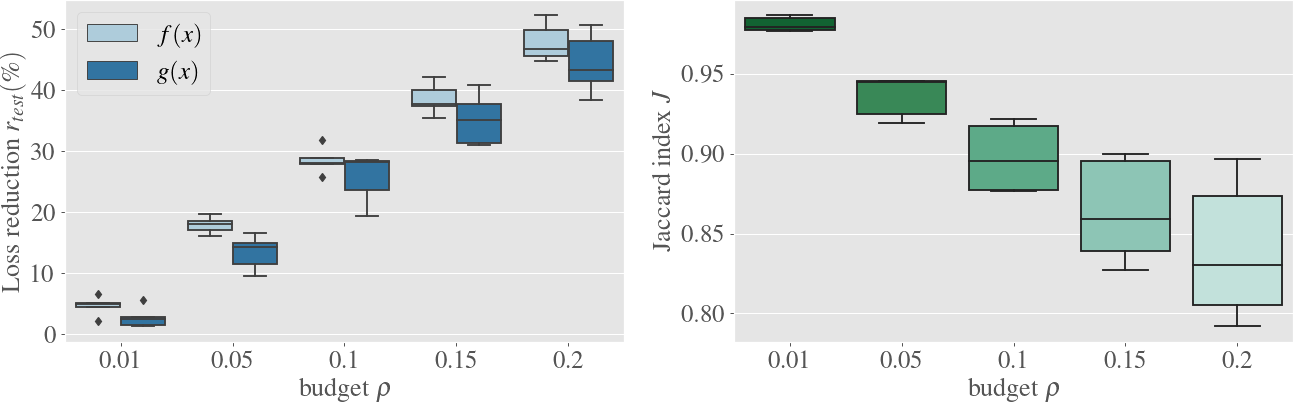

In [43]:
fig, ax = plt.subplots(1,2,figsize=(15, 5.1), constrained_layout=False, dpi=90)
pal = sns.color_palette('Paired')
sns.boxplot(x=df['rho_user'], y=df['%reduction_test'], hue='label', data=df, ax=ax[0], palette=pal)
ax[0].set_xlabel(r'budget $\rho$')
ax[0].set_ylabel(r'Loss reduction $r_{test}(\%)$')
ax[0].legend(loc='upper left')
pal = sns.color_palette('BuGn_r')
sns.boxplot(x=df_jaccard['rho_user'], y=df_jaccard['jaccard'], data=df_jaccard, ax=ax[1], palette=pal)
ax[1].set_xlabel(r'budget $\rho$')
ax[1].set_ylabel(r'Jaccard index $J$')
plt.tight_layout()
path_fig_fxgx = "drive/My Drive/NIPS2020/results/imdb/fig_fxgx_{clf}_yhat{yhat}_pca{pca}.pdf".format(clf=clf, pca=applyPCA, yhat=addPredictions)
plt.savefig(path_fig_fxgx, bbox_inches='tight', facecolor='w')

In [44]:
#reverse lookup
INDEX_FROM = 3
word_to_id = tf.keras.datasets.imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2
id_to_word = {value:key for key,value in word_to_id.items()}

In [45]:
rho = 0.01
rule = table_best.loc[table_best.rho_user == rho]['rule'].to_numpy()
eta = table_best.loc[table_best.rho_user == rho]['eta'].to_numpy()[0]
theta = crit_table_best.loc[crit_table_best.rho_user == rho]['thresh'].to_numpy()[0]
f_test = exp_best.gpr_mean_test+rule*np.sqrt(exp_best.gpr_var_test)
top_n = 20 # Top n selected instances in test set
top_f_idx = np.argpartition(f_test, -top_n)[-top_n:]
if clf=='svm':
    crit_test = np.abs(y_test_pred_soft_best.ravel())
    top_crit_idx = np.argpartition(crit_test, top_n)[:top_n]
elif clf=='softmax':
    p_test = np.concatenate((y_test_pred_soft_best,1-y_test_pred_soft_best),axis=1)
    crit_test = entropy(p_test, axis=1, base=2)
    top_crit_idx = np.argpartition(crit_test, -top_n)[-top_n:]
output_text = io.StringIO()
print('eta={},theta={}'.format(eta,theta))

eta=0.7773538157343864,theta=0.9994109869003296


In [46]:
output_text.write("top_n={}, rho_user={}, g(x)={}, addh_hat={}, PCA={}\n".format(top_n,rho,clf, addPredictions, applyPCA))
output_text.write("|f(x)>eta|={}(eta={:.3f}), |g(x)>theta|={}(theta={:.3f})\n".format(np.sum(f_test>eta), eta, np.sum(crit_test<theta) if clf=='svm' else np.sum(crit_test>theta), theta))
output_text.write("\nTop misclassfied instances picked by f(x)\n")
output_text.write("-----------------------------------------\n")
for i in top_f_idx:
  cond = f_test[i]>eta
  if y_test_best[i] != y_test_pred_th_best[i] and cond:
    output_text.write(' '.join([id_to_word[id] for id in X_test_best[i,:] if id!=0])+\
        '\n y={}'.format(y_test_best[i])+', y_pred={}'.format(y_test_pred_th_best[i])+\
        ', g(x)({})={:.3f}'.format('D' if clf=='svm' else 'H', crit_test[i])+\
        ', f(x)={:.3f}'.format(f_test[i])+'\n\n')
print(output_text.getvalue())

top_n=20, rho_user=0.01, g(x)=softmax, addh_hat=True, PCA=False
|f(x)>eta|=12(eta=0.777), |g(x)>theta|=14(theta=0.999)

Top misclassfied instances picked by f(x)
-----------------------------------------
<START> if the lion king is a serious story about a young lion growing up to <UNK> his father's death the lion king 1 and a half is the total opposite full of <UNK> and <UNK> the lion king told the story from the side of <UNK> the young lion 1 and a half is from the view of <UNK> and <UNK> a less than perfect duo made up of a <UNK> who left home because he could not dig <UNK> without <UNK> his friends and neighbors and a <UNK> who has an <UNK> issue the movie is a little short on substance but disney does a good job of <UNK> time with various <UNK> starring <UNK> and <UNK> as they watch the movie with us my favorite is the sing along that happens halfway through the movie make sure you watch the <UNK> <UNK> disney has <UNK> 1 and a half as the rest of the story though it really isn't i

In [47]:
output_text.write("\nTop misclassfied instances picked by g(x)\n")
output_text.write("-----------------------------------------\n")
for i in top_crit_idx:
  cond = crit_test[i]<theta if clf=='svm' else crit_test[i]>theta
  if y_test_best[i] != y_test_pred_th_best[i]:
    output_text.write(' '.join([id_to_word[id] for id in X_test_best[i,:] if id!=0])+\
        '\n y={}'.format(y_test_best[i])+', y_pred={}'.format(y_test_pred_th_best[i])+\
        ', g(x)({})={:.3f}'.format('D' if clf=='svm' else 'H', crit_test[i])+\
        ', f(x)={:.3f}'.format(f_test[i])+'\n\n')
print(output_text.getvalue())

top_n=20, rho_user=0.01, g(x)=softmax, addh_hat=True, PCA=False
|f(x)>eta|=12(eta=0.777), |g(x)>theta|=14(theta=0.999)

Top misclassfied instances picked by f(x)
-----------------------------------------
<START> if the lion king is a serious story about a young lion growing up to <UNK> his father's death the lion king 1 and a half is the total opposite full of <UNK> and <UNK> the lion king told the story from the side of <UNK> the young lion 1 and a half is from the view of <UNK> and <UNK> a less than perfect duo made up of a <UNK> who left home because he could not dig <UNK> without <UNK> his friends and neighbors and a <UNK> who has an <UNK> issue the movie is a little short on substance but disney does a good job of <UNK> time with various <UNK> starring <UNK> and <UNK> as they watch the movie with us my favorite is the sing along that happens halfway through the movie make sure you watch the <UNK> <UNK> disney has <UNK> 1 and a half as the rest of the story though it really isn't i

In [36]:
path_txt = "drive/My Drive/NIPS2020/results/imdb/instances_{clf}_yhat{yhat}_pca{pca}.txt".format(clf=clf, pca=applyPCA, yhat=addPredictions)
txt = open(path_txt, "w") 
txt.writelines(output_text.getvalue()) 
txt.close() #to change file access modes

In [ ]:
report_table_concat = pd.concat(report_table)
table_by_row_index = report_table_concat.groupby(report_table_concat.index)
report_table_mean = table_by_row_index.mean()
report_table_std = table_by_row_index.std()

report_criteria_concat = pd.concat(report_criteria)
table_by_row_index = report_criteria_concat.groupby(report_criteria_concat.index)
report_criteria_mean = table_by_row_index.mean()
report_criteria_std = table_by_row_index.std()

In [ ]:
report_table_mean

,rule,rho_user,error_val,L_val,%reduction_val,eta,p_value,check,budget,error_test,L_test,%reduction_test
0,1.06,0.01,0.00560,0.14192,3.786,0.820517,1.596467e-04,0.01,0.010,0.0049,0.1471,3.218
1,1.20,0.05,0.02472,0.12280,16.776,0.672585,1.438608e-20,0.05,0.054,0.0247,0.1273,16.284
2,0.84,0.10,0.04568,0.10184,31.026,0.448278,2.111505e-39,0.10,0.102,0.0457,0.1063,30.058
3,1.26,0.15,0.06064,0.08688,41.244,0.423398,1.133743e-41,0.15,0.154,0.0634,0.0886,41.738
4,0.12,0.20,0.07376,0.07376,50.104,0.136592,5.266706e-43,0.20,0.200,0.0775,0.0745,50.980


In [ ]:
report_criteria_mean

,rho_user,error_val,L_val,%reduction_val,thresh,budget,error_test,L_test,%reduction_test
0,0.01,0.00488,0.14264,3.306,0.998604,0.012,0.0057,0.1463,3.672
1,0.05,0.02320,0.12432,15.728,0.964553,0.054,0.0242,0.1278,15.878
2,0.10,0.04408,0.10344,29.916,0.885287,0.102,0.0452,0.1068,29.700
3,0.15,0.06088,0.08664,41.324,0.774637,0.152,0.0654,0.0866,43.020
4,0.20,0.07608,0.07144,51.648,0.668580,0.206,0.0825,0.0695,54.300


In [ ]:
report_table_std

,rule,rho_user,error_val,L_val,%reduction_val,eta,p_value,check,budget,error_test,L_test,%reduction_test
0,1.176010,0.0,0.001265,0.007034,0.797076,0.219716,3.569270e-04,0.0,0.000000,0.001817,0.009283,1.190869
1,1.104536,0.0,0.003025,0.007595,2.114800,0.264298,3.187349e-20,0.0,0.005477,0.002564,0.009425,1.828026
2,1.221884,0.0,0.002918,0.007857,2.533146,0.322871,4.721467e-39,0.0,0.008367,0.006535,0.008526,3.697022
3,1.047855,0.0,0.004495,0.010188,4.406856,0.203426,2.432024e-41,0.0,0.008944,0.006628,0.008569,3.804684
4,0.178885,0.0,0.005127,0.009045,4.302619,0.043197,1.177661e-42,0.0,0.010000,0.010186,0.009670,5.632673


In [ ]:
report_criteria_std

,rho_user,error_val,L_val,%reduction_val,thresh,budget,error_test,L_test,%reduction_test
0,0.0,0.000996,0.007357,0.659454,0.000779,0.004472,0.003054,0.007032,1.738094
1,0.0,0.002871,0.006832,1.788413,0.016886,0.005477,0.003347,0.007023,1.419972
2,0.0,0.002834,0.007164,2.081797,0.053454,0.008367,0.005251,0.006496,2.410187
3,0.0,0.004625,0.007785,3.379797,0.081735,0.008367,0.005067,0.005878,1.744506
4,0.0,0.005370,0.008341,4.106479,0.093708,0.008944,0.006225,0.006567,2.760860
